In [1]:
# Greatly inspired from https://github.com/ts1829/RL_Agent_Notebooks/blob/master/MountainCarv0/Mountain%20Car%20v0%20-%20Q%20Learning.ipynb

import matplotlib.pyplot as plt
import gym
import numpy as np
from tqdm import tqdm, trange
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
from datetime import datetime
import glob, os

In [2]:
env = gym.make('MountainCar-v0')
env.seed(1);
torch.manual_seed(1);
np.random.seed(1)

In [3]:
# I tried different weight initializations but found they did not perform well.
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Linear') != -1:
        nn.init.normal_(m.weight, 0, 1)

class Policy(nn.Module):
    def __init__(self):
        super(Policy, self).__init__()
        self.state_space = env.observation_space.shape[0]
        self.action_space = env.action_space.n
        self.hidden = 200
        self.l1 = nn.Linear(self.state_space, self.hidden, bias=False)
        self.l2 = nn.Linear(self.hidden, self.action_space, bias=False)
    
    def forward(self, x):    
        model = torch.nn.Sequential(
            self.l1,
            self.l2,
        )
        return model(x)

In [7]:
xs = torch.tensor([1, 2, 3], dtype=torch.float32, requires_grad=True)
print(xs)

print("No copy (same type)")
arr = np.array([1., 2., 3.])
xs = torch.from_numpy(arr).requires_grad_(True)
print(xs)
arr[0] = 3.
print(xs)

print("With copy (different type)")
arr = np.array([1., 2., 3.])
xs = torch.from_numpy(arr).type(torch.FloatTensor).requires_grad_(True)
print(xs)
arr[0] = 3.
print(xs)

print("With copy (no use of from_numpy)")
arr = np.array([1., 2., 3.])
xs = torch.FloatTensor(arr).requires_grad_(True)
print(xs)
arr[0] = 3.
print(xs)

print("Play with variable")
xs = torch.FloatTensor([1., 2., 3.]).requires_grad_(True)
ys1 = xs.clone()
ys2 = Variable(xs.clone().data)
ys3 = xs.clone().detach()
ys4 = xs.clone()
ys4.detach_()
print(ys1)
print(ys2)
print(ys3)
print(ys4)

tensor([1., 2., 3.], requires_grad=True)
No copy (same type)
tensor([1., 2., 3.], dtype=torch.float64, requires_grad=True)
tensor([3., 2., 3.], dtype=torch.float64, requires_grad=True)
With copy (different type)
tensor([1., 2., 3.], requires_grad=True)
tensor([1., 2., 3.], requires_grad=True)
With copy (no use of from_numpy)
tensor([1., 2., 3.], requires_grad=True)
tensor([1., 2., 3.], requires_grad=True)
Play with variable
tensor([1., 2., 3.], grad_fn=<CloneBackward>)
tensor([1., 2., 3.])
tensor([1., 2., 3.])
tensor([1., 2., 3.])


100%|██████████████████████████████████████████████████████████████████████████████| 2500/2500 [02:51<00:00, 14.54it/s]


successful episodes: 471 - 18.8400%


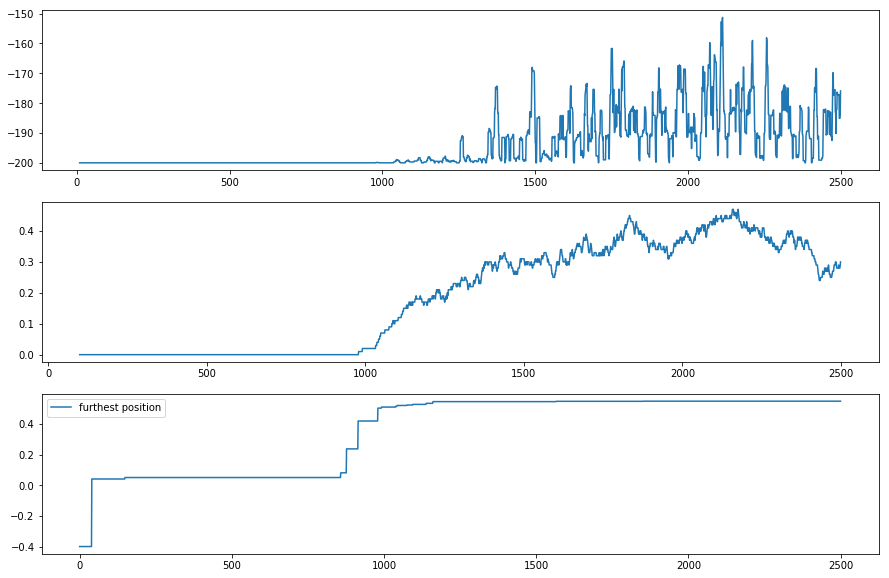

In [21]:
episodes = 2500

epsilon = 0.3
reward_discount = 0.99

success_count = 0
reward_history = []
max_positions = [-0.4]
successes = []

policy = Policy()
criterion = nn.MSELoss()
optimizer = optim.SGD(policy.parameters(), lr=1e-3)
# optimizer = optim.Adam(policy.parameters(), lr=1e-3) # interestingly, Adam does not lead to good results...
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.9)

for episode in trange(episodes):
    episode_loss = 0
    episode_reward = 0
    state = env.reset()

    done = False
    while not done:
        # Get first action value function
        Q = policy(torch.FloatTensor(state))
        
        # Choose epsilon-greedy action
        if np.random.rand(1) < epsilon:
            action = np.random.randint(0,3)
        else:
            _, action = torch.max(Q, -1)
            action = action.item()
        
        # Step forward and receive next state and reward
        next_state, reward, done, _ = env.step(action)
        
        # Find max Q for t+1 state
        Q1 = policy(torch.FloatTensor(next_state))
        maxQ1, _ = torch.max(Q1, -1)
        
        # Create target Q value for training the policy
        Q_target = Q.clone()
        Q_target.detach_() # Q_target = Variable(Q_target.data)
        Q_target[action] = reward + maxQ1.detach() * reward_discount
        
        # Calculate loss & Update policy
        optimizer.zero_grad()
        loss = criterion(Q, Q_target)
        loss.backward()
        optimizer.step()

        # Record history
        episode_loss += loss.item()
        episode_reward += reward
        
        if done:
            if next_state[0] >= env.goal_position: # On successful epsisodes
                epsilon *= .99     # Adjust epsilon
                scheduler.step()   # Adjust learning rate
                success_count += 1 
                successes.append(1)
            else:
                successes.append(0)
            
            max_positions.append(max(max_positions[-1], next_state[0]))
            reward_history.append(episode_reward)
        
        state = next_state
            
print('successful episodes: {:d} - {:.4f}%'.format(success_count, success_count/episodes*100))

fig, ax = plt.subplots(figsize=(15, 10), nrows=3)
ax[0].plot(pd.Series(reward_history).rolling(10).mean(), label="rewards")
ax[1].plot(pd.Series(successes).rolling(100).sum() / 100., label="success rate")
ax[2].plot(max_positions, label="furthest position")
plt.legend()
plt.show()